# Wine Recommend

## [1] 데이터 로딩

In [13]:
# importing inportant libraries
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
# Reading dataset
import pandas as pd
df = pd.read_csv('C:/Users/ss/Desktop/winereview/winemag-data-130k-v2.csv')

# checking the shape of the data
df.shape

(129971, 14)

In [8]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## [2] 데이터 전처리

In [9]:
# We only require the description and variety of grapes
df = df[['description', 'variety']]
df.head()

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir


In [10]:
temp_df = df.variety.value_counts()
temp_df.head(10)

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Riesling                     5189
Sauvignon Blanc              4967
Syrah                        4142
Rosé                         3564
Merlot                       3102
Name: variety, dtype: int64

In [12]:
# variety counts 상위 7개 
mask = df['variety'].isin(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc'])
df = df[mask]
df.head()

,description,variety
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir
10,"Soft, supple plum envelopes an oaky structure ...",Cabernet Sauvignon
12,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon
14,Building on 150 years and six generations of w...,Chardonnay


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


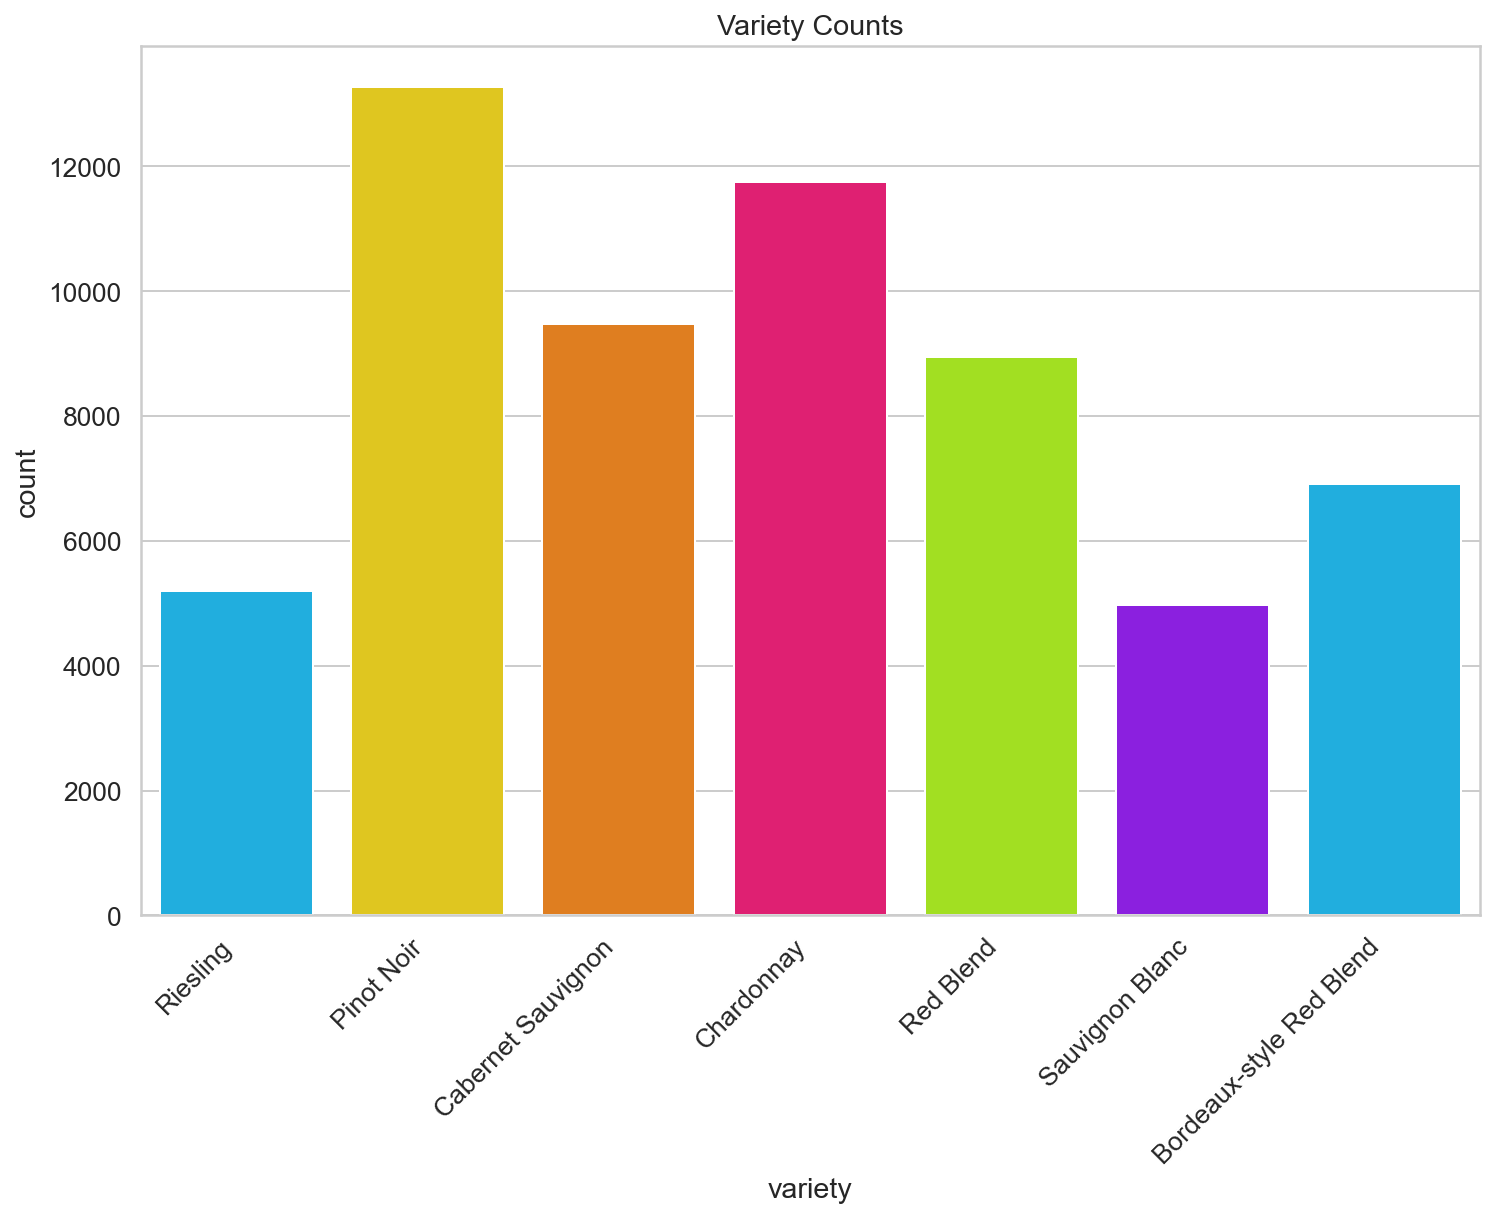

In [16]:
chart = sns.countplot(df.variety, palette=COLORS)
plt.title("Variety Counts")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

### [2-1] train, test 분리

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.description, df.variety, test_size = 0.2, random_state = 42)

In [28]:
train_df = pd.concat((X_train,y_train),axis=1)
test_df = pd.concat((X_test,y_test),axis=1)

In [30]:
train_df = train_df.rename(columns={'description':'text', 'variety':'intent'})
test_df = test_df.rename(columns={'description':'text', 'variety':'intent'})

In [31]:
train_df.head()

,text,intent
94842,This fine offering from Victoria's Mornington ...,Pinot Noir
40949,"Soft and warm, this wine originates from the n...",Pinot Noir
97683,"Aimed at the millennial market, this Bob Lindq...",Red Blend
77614,A blend of Stillwater Creek and Dineen vineyar...,Cabernet Sauvignon
87163,Bright raspberry aromas are cut by a slightly ...,Pinot Noir


In [32]:
test_df.head()

,text,intent
122928,"This wine is sour, flat and past its prime, sh...",Cabernet Sauvignon
85044,"Made with organically grown grapes, this ripe,...",Red Blend
106244,"For a huge-volume wine, it's what we'd expect....",Cabernet Sauvignon
60406,"This is a clean, lightweight wine with grippin...",Cabernet Sauvignon
41009,"Darkly tannic, this wine has a dense structure...",Bordeaux-style Red Blend


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


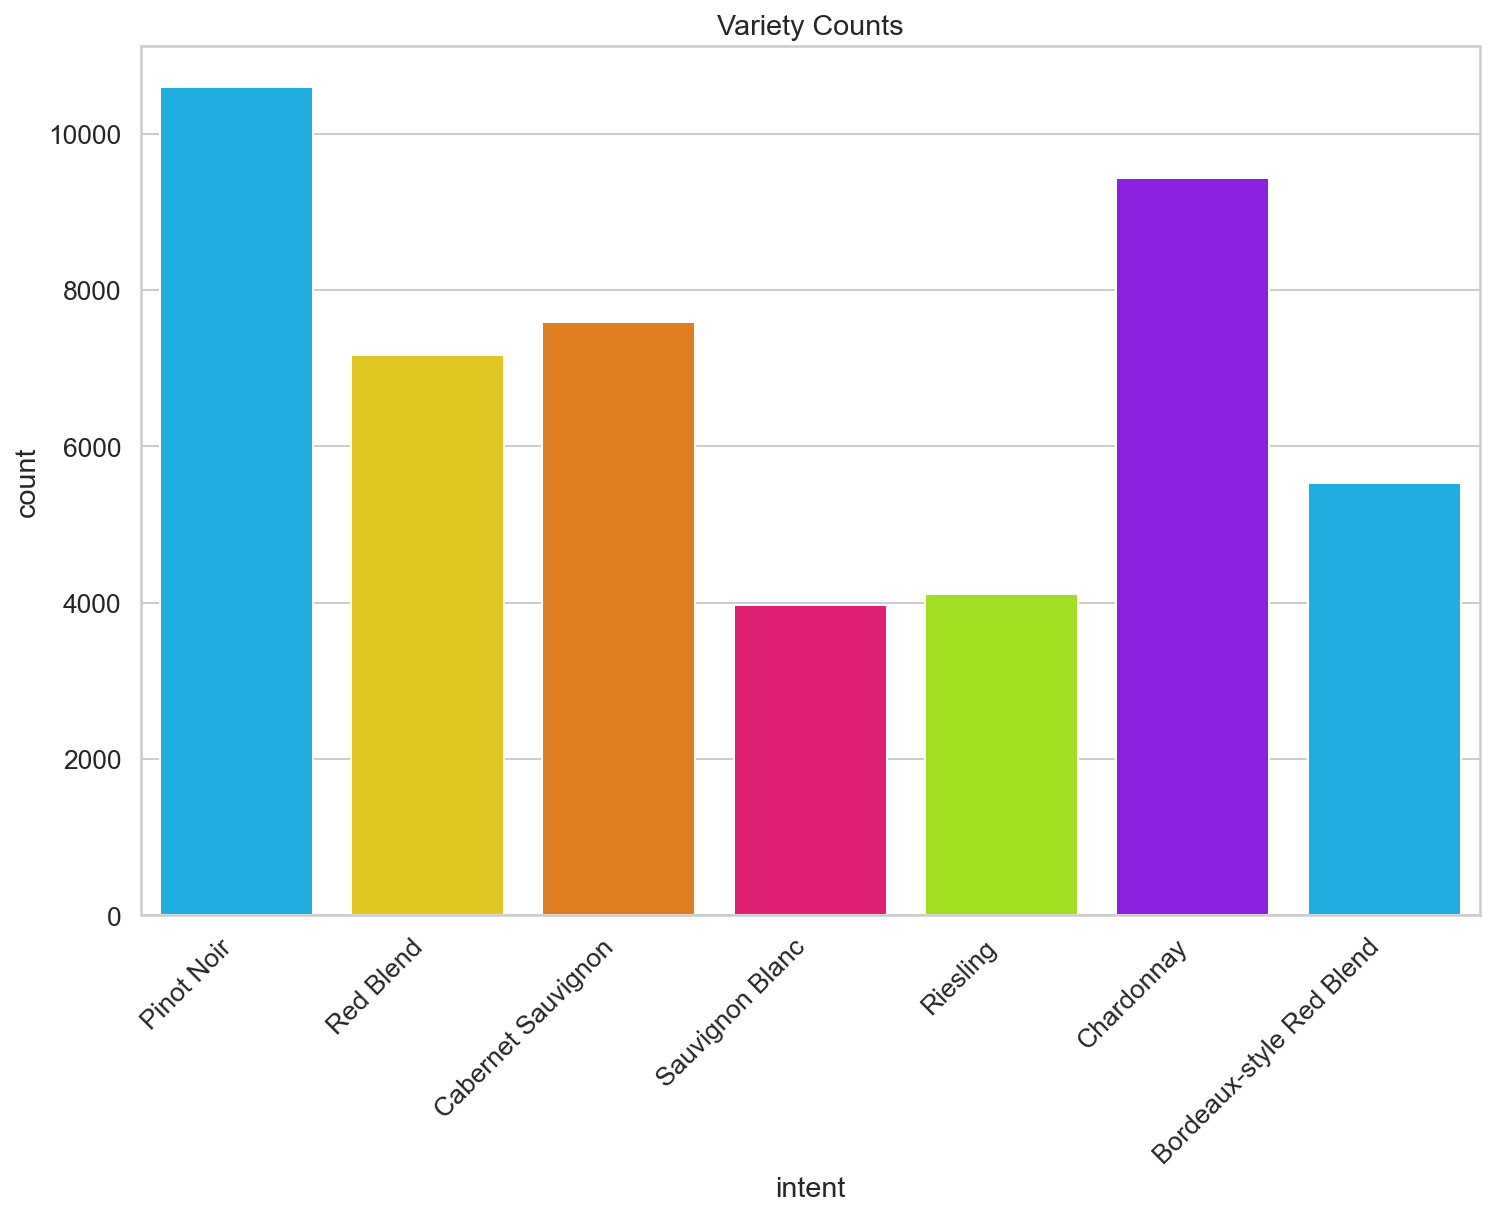

In [34]:
chart = sns.countplot(train_df.intent, palette=COLORS)
plt.title("Variety Counts")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

### [2-2] Under Sampling

In [35]:
sauvignon_blanc_df = train_df[train_df['intent']=='Sauvignon Blanc']
riesling_df = train_df[train_df['intent']=='Riesling']
pinot_noir_df = train_df[train_df['intent']=='Pinot Noir']
chardonnay_df = train_df[train_df['intent']=='Chardonnay']
cabernet_sauvignon_df = train_df[train_df['intent']=='Cabernet Sauvignon']
red_blend_df = train_df[train_df['intent']=='Red Blend']
bordeaux_style_red_blend_df = train_df[train_df['intent']=='Bordeaux-style Red Blend']

In [36]:
pinot_noir_df = pinot_noir_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
chardonnay_df = chardonnay_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
cabernet_sauvignon_df = cabernet_sauvignon_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
red_blend_df = red_blend_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
bordeaux_style_red_blend_df = bordeaux_style_red_blend_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
riesling_df = riesling_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)

In [37]:
len(sauvignon_blanc_df)

3969

In [38]:
sauvignon_blanc_df = sauvignon_blanc_df.append(pinot_noir_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(chardonnay_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(cabernet_sauvignon_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(red_blend_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(bordeaux_style_red_blend_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(riesling_df).reset_index(drop=True)
train_df = sauvignon_blanc_df
train_df.shape

C:\Users\ss\AppData\Local\Temp\ipykernel_5780\828095010.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sauvignon_blanc_df = sauvignon_blanc_df.append(pinot_noir_df).reset_index(drop=True)
C:\Users\ss\AppData\Local\Temp\ipykernel_5780\828095010.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sauvignon_blanc_df = sauvignon_blanc_df.append(chardonnay_df).reset_index(drop=True)
C:\Users\ss\AppData\Local\Temp\ipykernel_5780\828095010.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sauvignon_blanc_df = sauvignon_blanc_df.append(cabernet_sauvignon_df).reset_index(drop=True)
C:\Users\ss\AppData\Local\Temp\ipykernel_5780\828095010.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas

(27783, 2)

In [39]:
train_df

,text,intent
0,This Sauvignon Blanc looks only slightly more ...,Sauvignon Blanc
1,A nose of cut herbs and just-mown grass backed...,Sauvignon Blanc
2,"Attractively fruity, this wine is soft and ful...",Sauvignon Blanc
3,"Cidery apple aromas, a medium-bodied citrusy p...",Sauvignon Blanc
4,Basic citrus and green-leaning aromas introduc...,Sauvignon Blanc
...,...,...
27778,"This is an excellent Harvest Select bottling, ...",Riesling
27779,"Intense smoky, slatey complexities lend an ear...",Riesling
27780,This smells superripe—the fruit seems almost c...,Riesling
27781,"Off-dry, this succulent wine has you smacking ...",Riesling


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


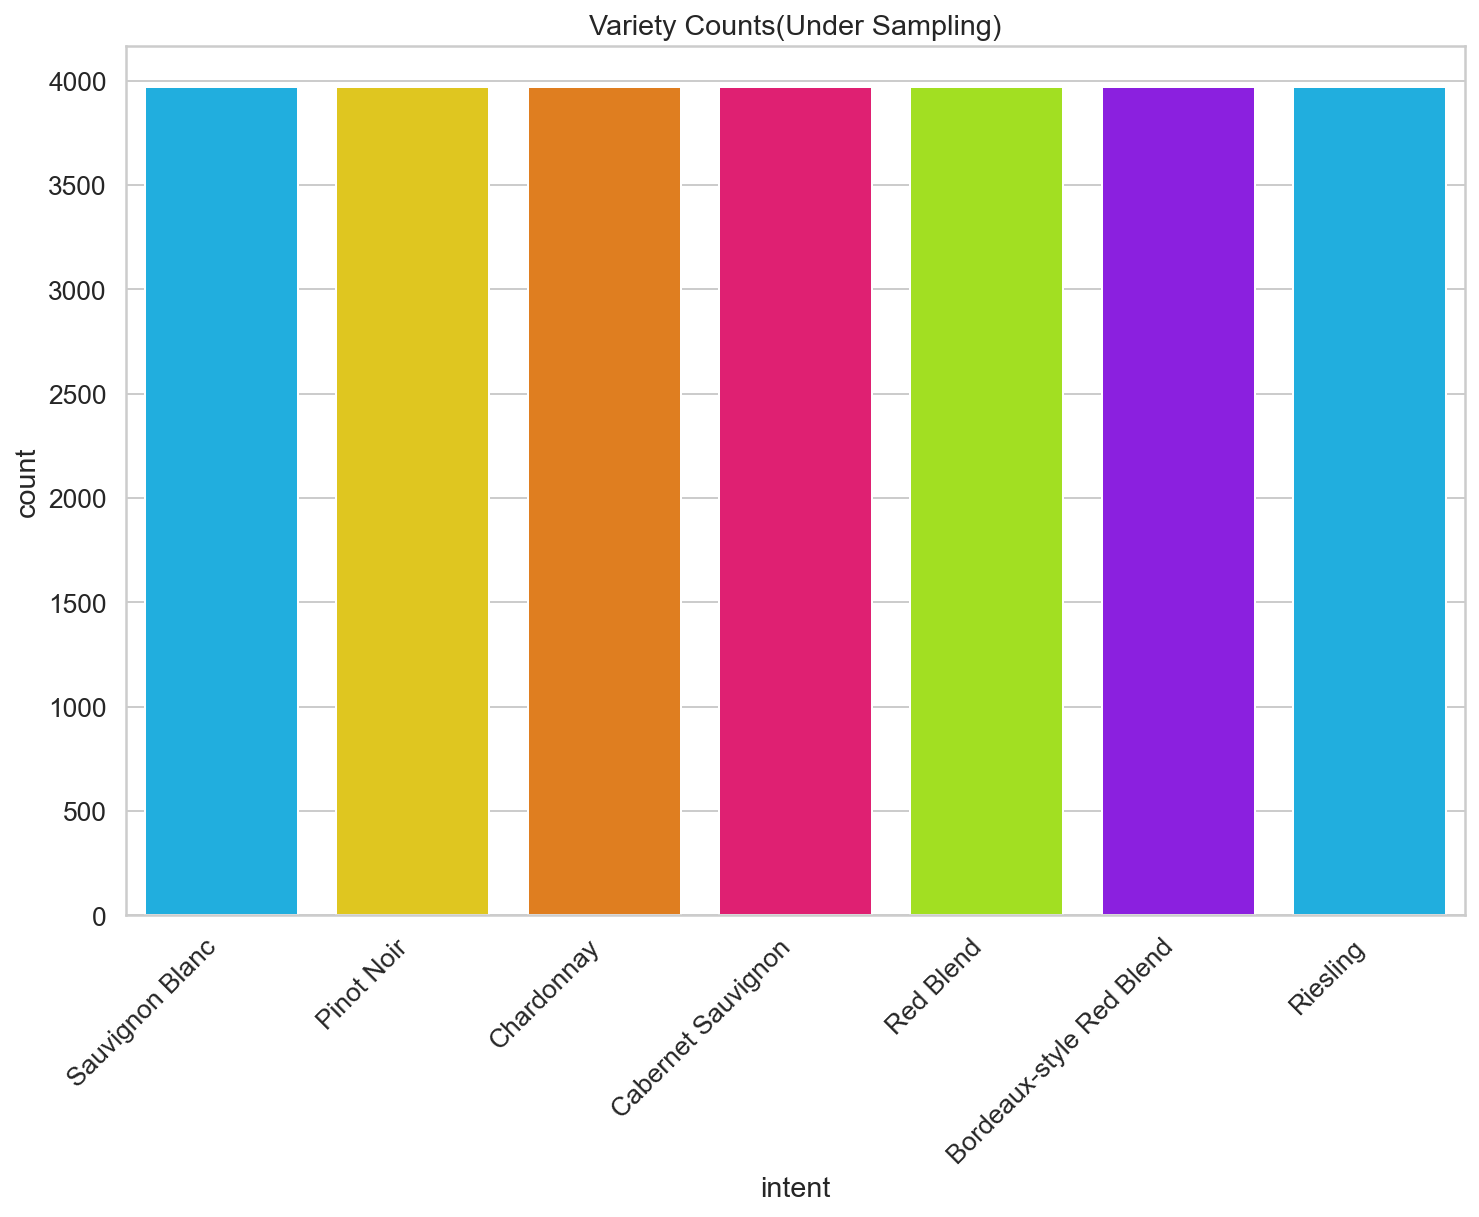

In [41]:
chart = sns.countplot(train_df.intent, palette=COLORS)
plt.title("Variety Counts(Under Sampling)")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [45]:
# Data Suffling
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(10)

,text,intent
0,"A blend of Sangiovese and 10% Canaiolo, this e...",Red Blend
1,A touch of minerality on the nose comes with a...,Sauvignon Blanc
2,"This is an intriguing, complex rendering of Sa...",Sauvignon Blanc
3,"A wine that is currently closed, this shows hi...",Chardonnay
4,"Full and soft, this is a ripe and creamy wine,...",Chardonnay
5,It's a shame so much high-toast wood was used ...,Bordeaux-style Red Blend
6,"Pure in character, this has a taut line of per...",Riesling
7,"An estate wine blended with 6% Sémillon, this ...",Sauvignon Blanc
8,"A delicate expression of power and beauty, thi...",Pinot Noir
9,Opulent white blossom and tropical fruit flavo...,Riesling


In [46]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
